In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys
sys.path.append(f'/media/beans/ssd/bespoke')

from constants import *
from imports import *
from viz_utils import *
from train_utils import *
from input_prep import *
from traj_utils import *

/home/beans/miniconda3/envs/py38/lib/python3.8/site-packages/albumentations/augmentations/transforms.py:689: FutureWarning: This class has been deprecated. Please use CoarseDropout
  warnings.warn(
/home/beans/miniconda3/envs/py38/lib/python3.8/site-packages/albumentations/augmentations/transforms.py:965: FutureWarning: This class has been deprecated. Please use ImageCompression
  warnings.warn(


### Seq from real

In [2]:
sorted(glob.glob("/media/beans/ssd/bespoke_logging/*"))

['/media/beans/ssd/bespoke_logging/run_173',
 '/media/beans/ssd/bespoke_logging/run_174',
 '/media/beans/ssd/bespoke_logging/run_175',
 '/media/beans/ssd/bespoke_logging/run_176',
 '/media/beans/ssd/bespoke_logging/run_176a',
 '/media/beans/ssd/bespoke_logging/run_176b',
 '/media/beans/ssd/bespoke_logging/run_176c',
 '/media/beans/ssd/bespoke_logging/run_176d',
 '/media/beans/ssd/bespoke_logging/run_176e',
 '/media/beans/ssd/bespoke_logging/run_176f',
 '/media/beans/ssd/bespoke_logging/run_176g',
 '/media/beans/ssd/bespoke_logging/run_177',
 '/media/beans/ssd/bespoke_logging/run_178',
 '/media/beans/ssd/bespoke_logging/run_178a',
 '/media/beans/ssd/bespoke_logging/run_178b',
 '/media/beans/ssd/bespoke_logging/run_179',
 '/media/beans/ssd/bespoke_logging/run_179a',
 '/media/beans/ssd/bespoke_logging/run_180',
 '/media/beans/ssd/bespoke_logging/run_181',
 '/media/beans/ssd/bespoke_logging/run_182',
 '/media/beans/ssd/bespoke_logging/run_183',
 '/media/beans/ssd/bespoke_logging/run_184',


In [37]:
#run_id = "run_382" # out sabq to pow to grade
run_id = "run_383" # back from grade, 214, madrona
# run_id = "run_392" # back from nabq, creeper on ev

run_path = f"/media/beans/ssd/bespoke_logging/{run_id}"
model_stem = "7.1_avg"

In [38]:
aux = np.stack([np.load(f) for f in sorted(glob.glob(f"{run_path}/aux/*"))]).astype(np.float16)
img = np.stack([np.load(f) for f in sorted(glob.glob(f"{run_path}/img/*"))]).astype(np.uint8)
car_state = np.stack([np.load(f) for f in sorted(glob.glob(f"{run_path}/car_state/*"))]).astype(np.float16)

steer_angle = np.radians(car_state[:,0] / (STEER_RATIO)) #*-1  
tire_angle_rad = steer_angle *-1
img.shape

(41432, 100, 640, 3)

In [39]:
commanded_torque = car_state[:, 7]

array([7.2000e+01, 6.3700e+03, 3.4189e+04, 7.4400e+02, 1.1000e+01,
       1.1000e+01, 1.1000e+01, 6.0000e+00, 9.0000e+00, 9.0000e+00])

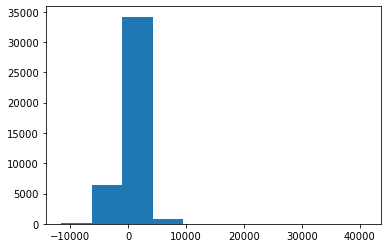

In [40]:
plt.hist(commanded_torque)[0]

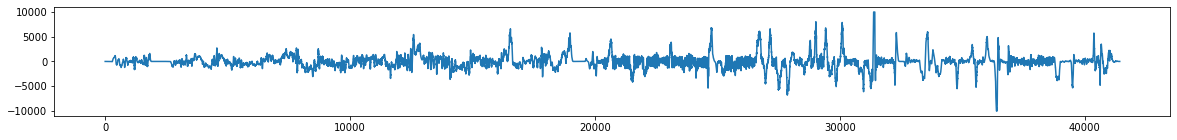

In [41]:
plt.figure(figsize=(20,2))
plt.plot(np.clip(commanded_torque, -10_000, 10_000))

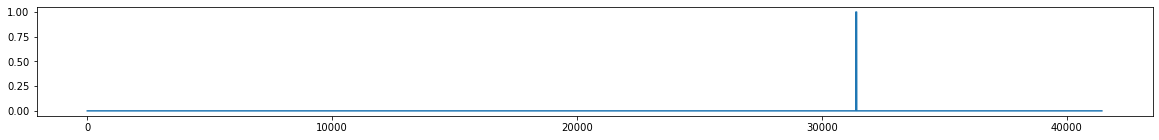

In [42]:
# abs torque limited
plt.figure(figsize=(20,2))
plt.plot(car_state[:, 9])

array([  410.,   232.,   272.,  1309., 18091., 18659.,  1136.,   286.,
         255.,   782.])

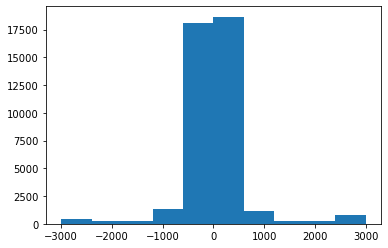

In [43]:
commanded_td = car_state[:, 8]
plt.hist(np.clip(commanded_td, -3000, 3000))[0]

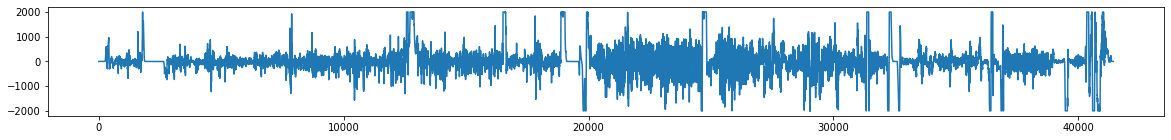

In [44]:
plt.figure(figsize=(20,2))
plt.plot(np.clip(commanded_td, -2000, 2000))

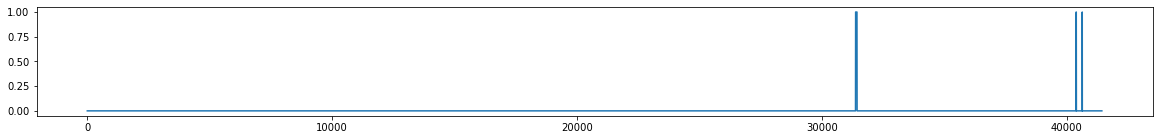

In [45]:
# Td limited
plt.figure(figsize=(20,2))
plt.plot(car_state[:, 10])

In [46]:
# interesting note
plt.figure(figsize=(20,2))
plt.plot(car_state[:, 11])

IndexError: index 11 is out of bounds for axis 1 with size 11

<Figure size 1440x144 with 0 Axes>

In [47]:
import plotly.express as px
import plotly.graph_objects as go

fig = px.scatter(car_state[:, 10], width=900, height=400)
fig.show()

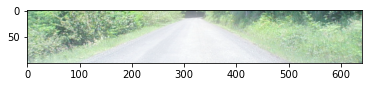

In [48]:
plt.imshow(img[15_750])

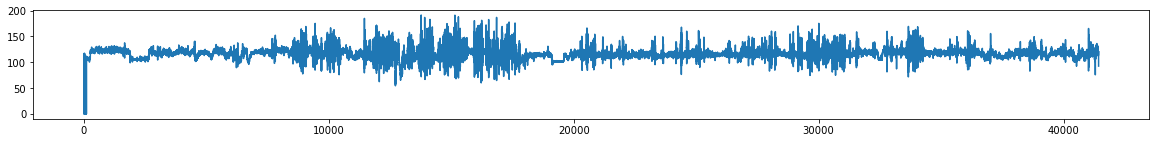

In [49]:
# seeing if cam is too slow, ie if we ever have repeated imgs

diffs = []
for i in range(len(img)-1):
    diff = (img[i] - img[i+1]).mean()
    diffs.append(diff)
    
# whether or not image is same as prev img, ie cam is slow. We just don't want to see zeros
plt.figure(figsize=(20,2))
plt.plot(diffs)

(array([3.8000e+01, 1.0410e+03, 1.8043e+04, 0.0000e+00, 2.0193e+04,
        1.6550e+03, 0.0000e+00, 2.9100e+02, 4.8000e+01, 0.0000e+00,
        3.3000e+01, 2.6000e+01, 2.8000e+01, 0.0000e+00, 1.3000e+01,
        6.0000e+00, 0.0000e+00, 6.0000e+00, 3.0000e+00, 8.0000e+00]),
 array([15. , 15.7, 16.4, 17.1, 17.8, 18.5, 19.2, 19.9, 20.6, 21.3, 22. ,
        22.7, 23.4, 24.1, 24.8, 25.5, 26.2, 26.9, 27.6, 28.3, 29. ],
       dtype=float16),
 <BarContainer object of 20 artists>)

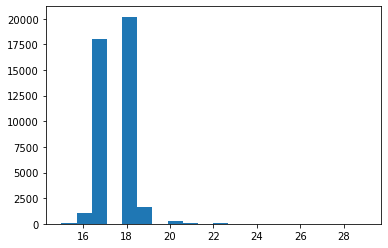

In [50]:
# timespan btwn start to get img, and publish plan, ie the timespan WE have control over
# img staleness
plt.hist(car_state[:,2], bins=20)

In [51]:
b,e = 0, -1
img = img[b:e]
aux = aux[b:e]
car_state = car_state[b:e]
steer_angle = steer_angle[b:e]
img.shape, aux.shape, car_state.shape, steer_angle.shape, #pred.shape

((41431, 100, 640, 3), (41431, 5), (41431, 11), (41431,))

(array([  232.,   404.,  1491.,  6319., 27144.,  4397.,   642.,   522.,
          212.,    68.]),
 array([-6572., -5096., -3622., -2148.,  -673.,   802.,  2276.,  3752.,
         5228.,  6700.,  8176.], dtype=float16),
 <BarContainer object of 10 artists>)

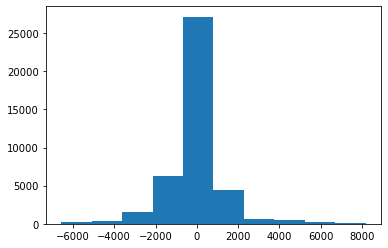

In [52]:
torque = np.degrees(steer_angle) * (aux[:,2]**2)
plt.hist(torque)

(array([7.0000e+00, 3.5000e+01, 1.1200e+02, 6.3000e+02, 4.7870e+03,
        3.1465e+04, 3.7630e+03, 5.3800e+02, 7.7000e+01, 1.6000e+01]),
 array([-556. , -453.5, -351.2, -248.8, -146.4,  -44. ,   58.4,  160.8,
         263.2,  365.5,  468. ], dtype=float16),
 <BarContainer object of 10 artists>)

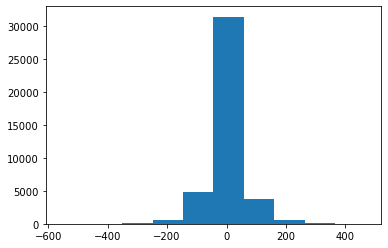

In [53]:
plt.hist(torque[1:]-torque[:-1])

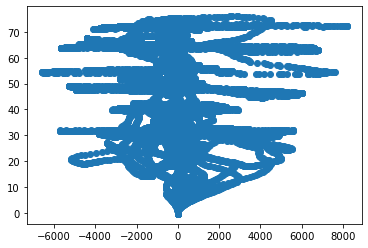

In [54]:
plt.scatter(torque, aux[:,2])

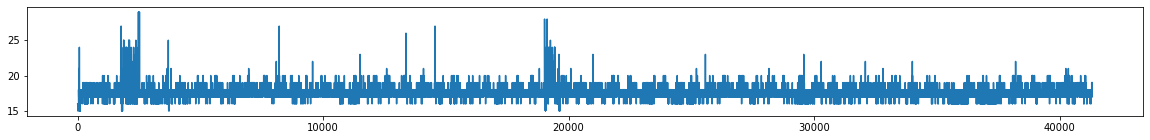

In [55]:
# img staleness
plt.figure(figsize=(20,2))
plt.plot(car_state[100:,2])

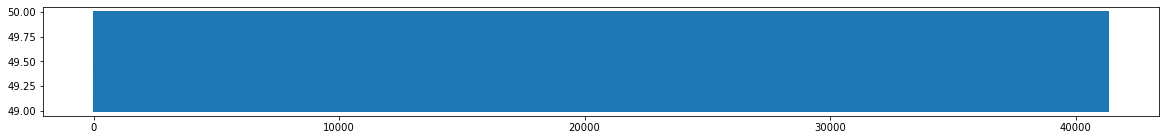

In [56]:
# loop duration
plt.figure(figsize=(20,2))
plt.plot(car_state[100:,3])

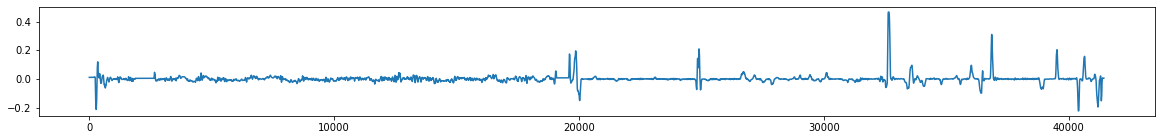

In [57]:
# steer angle
plt.figure(figsize=(20,2))
plt.plot(steer_angle)

In [58]:
import plotly.express as px
import plotly.graph_objects as go

fig = px.scatter(x=range(len(steer_angle)), y=steer_angle, width=900, height=400)
fig.show()

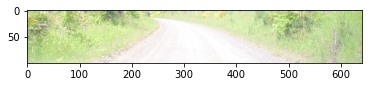

In [59]:
plt.imshow(img[6644])

(array([1.3700e+02, 2.5200e+02, 3.3830e+03, 3.6771e+04, 4.2500e+02,
        2.6700e+02, 7.6000e+01, 4.1000e+01, 1.5000e+01, 6.4000e+01]),
 array([-0.2217 , -0.1528 , -0.084  , -0.01514,  0.0537 ,  0.12256,
         0.1914 ,  0.2603 ,  0.329  ,  0.398  ,  0.4668 ], dtype=float16),
 <BarContainer object of 10 artists>)

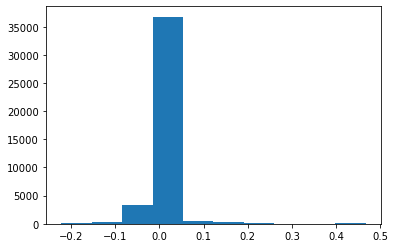

In [60]:
plt.hist(steer_angle)

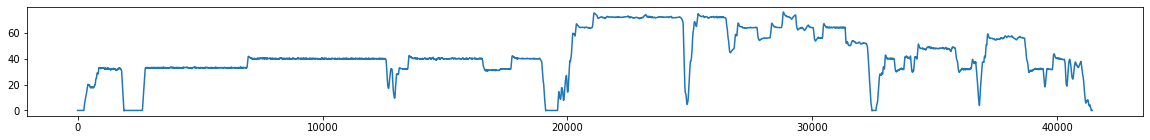

In [61]:
# speed
plt.figure(figsize=(20,2))
plt.plot(aux[:,2])

(array([ 2240.,   760.,  1010.,  1183.,  9625., 11711.,  2659.,  2956.,
         3843.,  5444.]),
 array([-0.331,  7.3  , 14.94 , 22.56 , 30.2  , 37.84 , 45.47 , 53.1  ,
        60.72 , 68.4  , 76.   ], dtype=float16),
 <BarContainer object of 10 artists>)

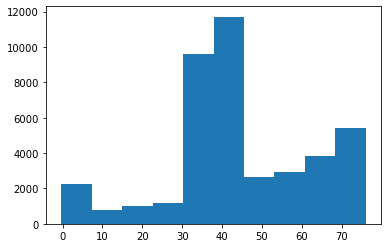

In [62]:
# speed
plt.hist(aux[:,2])

In [63]:
kph_to_mph = lambda x : x / 1.609

In [64]:
max_speed_lookup_rollout = [
    (.157, 16.6),
    (.11, 20),
    (.071, 25.5),
    (.052, 28.7),
    (.037, 34.1),
    (.027, 39.3),
    (.021, 44.7),
    (.018, 50), # this is a guess, TODO update this
]
max_speed_bps_rollout = [x[0] for x in max_speed_lookup_rollout][::-1]
max_speed_vals_rollout = [x[1] for x in max_speed_lookup_rollout][::-1]

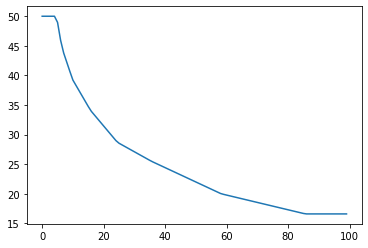

In [65]:
plt.plot([np.interp(x, max_speed_bps_rollout, max_speed_vals_rollout) for x in np.linspace(.01, .18, 100)])

In [66]:
import plotly.express as px
import plotly.graph_objects as go

fig = px.scatter(x=kph_to_mph(aux[:, 2]), y=abs(steer_angle), width=600, height=600)
fig.update_xaxes(range=[0, 50])
fig.update_yaxes(range=[0, .2])
fig.show()

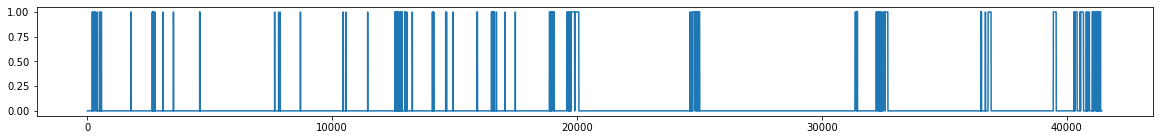

In [67]:
# steeringWheelPressed
plt.figure(figsize=(20,2))
plt.plot(car_state[:,4])

(array([  337165.,  3954027.,  8983990., 11892653., 15820303., 18672746.,
        19585949., 14428190., 25278786., 13654191.]),
 array([  0. ,  25.5,  51. ,  76.5, 102. , 127.5, 153. , 178.5, 204. ,
        229.5, 255. ]),
 <BarContainer object of 10 artists>)

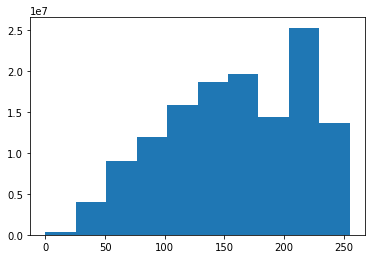

In [68]:
plt.hist(img[::20,:,:,2].flatten())

In [69]:
img.mean()

178.32240763722112

In [70]:
make_vid(run_id, model_stem, img, aux)

(41431, 30) (41431, 1, 13, 80) (41431, 1, 13, 80)
Made vid!


In [ ]:
preds_all, obsnet_outs, cnn_activations, cnn_grads, rnn_activations, rnn_grads = get_viz_rollout(model_stem, img, aux)
preds_all.shape

In [ ]:
speeds = aux[:,2]
wp_angles = gather_preds(preds_all, speeds)

In [ ]:
b, e = 0, -1
plt.figure(figsize=(20,5))
plt.plot(steer_angle[b:e])
plt.plot(np.array(wp_angles[b:e]*-1)) 

In [ ]:
speeds_mps = kph_to_mps(aux[:,2])
trajs = torch.FloatTensor(preds_all[:,:N_WPS_TO_USE]).to('cuda')
traj_xs, traj_ys = get_trajs_world_space(trajs, speeds_mps, tire_angle_rad, CRV_WHEELBASE)
traj_xs.shape

In [ ]:
import plotly.express as px
import plotly.graph_objects as go

fig = px.scatter(x=traj_xs[::8].cpu().numpy().flatten(), y=traj_ys[::8].cpu().numpy().flatten(), width=900, height=900)
fig.update_yaxes(range=[0, 1500])
fig.update_xaxes(range=[-1500, 0])
fig.show()

In [ ]:
temporal_error = get_temporal_error(traj_xs, traj_ys, speeds_mps)
temporal_error_sqrt = np.sqrt(temporal_error.cpu())

In [ ]:
_make_vid(model_stem, run_id, preds_all, img, 
             cnn_grads, cnn_activations, rnn_grads, rnn_activations, temporal_error_sqrt)

In [ ]:
preds_all.shape